## Importy

In [21]:
# pip install pygad
# pip install joblib

In [22]:
import math
import pygad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)


## Wczytywanie konfiguracji pana Marcina
Pliki z konfiguracjami można pobrać z https://github.com/D3M80L/CA/tree/master/phd/data.

In [3]:
def convert_configuration(configuration: bytes, N: int):
    binary_str = ''.join(f'{byte:08b}' for byte in configuration)
    return np.array([int(bit) for bit in binary_str[:N]])


In [4]:
def configuration_reader(file_name: str, N: int, negate: bool):
    bytes_per_configuration = math.ceil(N / 8)
    configurations = []

    with open(file_name, 'rb') as file:
        while True:
            bytes_read = file.read(bytes_per_configuration)
            if not bytes_read:
                break

            cfg = convert_configuration(bytes_read, N)
            configurations.append(cfg)
            
            if negate:
                configurations.append(1 - cfg)

    return np.stack(configurations)


---
# zad.9 (lekko zmodyfikowane)

Zapoznaj się z wynikami z artykułu:\
*Mendonça, J. R. G. (2019).* **Simply modified GKL density classifiers that reach consensus faster.** *Physics Letters A, 383(19), 2264–2266. 
doi:10.1016/j.physleta.2019.04.033* (https://sci-hub.se/https://www.sciencedirect.com/science/article/abs/pii/S0375960119303512?via=ihub)

Spróbuj powtórzyć eksperymenty tam wykonane dla wybranego N dla którego mamy "zbiór Marcina" % poprawnych klasyfikacji dla reguł GKL(j, k) dla kilku, wybranych przez Ciebie przypadków j, k. **Wariant (*) - zbadaj również średni czas klasyfikacji - tzn. czy widać, które reguły są szybsze od innych.**

---
# zad.11

Zaimplementuj algorytm ewolucyjny, który poszukuje rozwiązań DCP wśród binarnych automatów komórkowych o promieniu sąsiedztwa r=2, dla liczby komórek N=23 (korzystając ze zbioru Marcina) i limitu czasu T = 2*N. Zdecyduj sama / sam ile populacji i jak duże populacje potrzebujesz - możesz to określić robiąc eksperymenty. Możesz również dowolnie manipulować mutacjami, krzyżowaniem, selekcją itd.

Jaki najlepszy wynik (największą liczbę poprawnie sklasyfikowanych konfiguracji) uda Ci się uzyskać? Podaj LUT najlepszej, znalezionej przez Twój algorytm reguły. 

Uzyskane przez nas wszystkich reguły porównam na zbiorach N=23 i większych, jak tylko otrzymam wszystkie rozwiązania i wyłonimy zwycięzców. Może uda się komuś z nas pobić GKL?

Sugestie:
- Do wstępnych testów możesz najpierw użyć mniejszego N i zamiast zbioru Marcina, użyć mniejszy zbiór wygenerowany losowo - program będzie działać szybciej, zatem szybciej będziesz wprowadzać w nim zmiany.
- Koniecznie użyj przetwarzania równoległego aby w pełni wykorzystać moc współczesnych procesorów oraz cache’owania - tak, żeby nie przeliczać tej samej reguły CA wiele razy.
- GitHub CodeSpaces dają 4-rdzeniowy procesor w chmurze dostępny za darmo (30 lub 60 godzin obliczeń w miesiącu).
- Czy dla każdego wyliczenia wartości funkcji dopasowania trzeba używać cały zbiór warunków początkowych? Może aby było szybciej, dla każdej populacji można losować pewien podzbiór zbioru warunków początkowych i dzięki temu szybciej tworzyć nowe populacje? (A może te podzbiory też powinny podlegać “ewolucji”? Mamy wtedy do czynienia z koewolucją.)
- Przedyskutuj to zagadnienie z ChatGPT. Poproś o sugestie, pomysły na usprawnienia kodu itd!

In [ ]:
# ECA to automaty o promieniu r=1, teraz mamy r=2, czyli sąsiedztwo 5!!
# trzeba zmodyfikować eca_get_lut(do 32 a nie 8) i eca_evolve(na filmiku pan mówi)
# podać lut, który wyszedł jako najlepszy!!

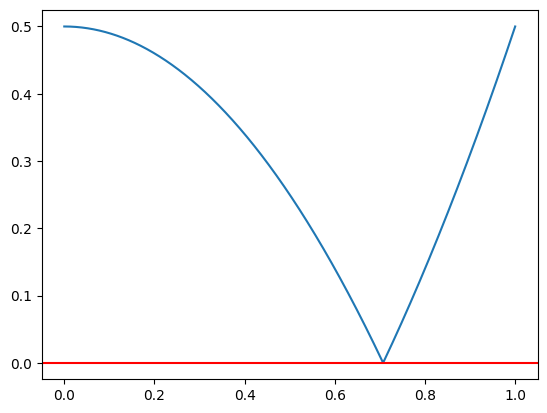

Best candidate:  0.707089657400412
Exact solution:  0.7071067811865475
Difference between best and exact:  1.712378613549781e-05
Error (value of |f(best candidate)|):  2.4216397368048703e-05


In [16]:
# przykład zastosowania algorytmu genetycznego
def interval(x):
    return max(0.0, min(x, 1.0))

def cross(x, y):
    return 0.5 * (x+y)

def mutate(x):
    return interval(x + (np.random.random() - 0.5) * 0.005)

def fitness(x, func):
    return np.abs(func(x))

def fitness_on_population(population, func):
    res = np.array([fitness(x, func) for x in population])
    res = 1.0 - (res/np.max(res))
    s = sum(res)
    return res / s

def choice(population, fitness_values):
    return np.random.choice(population, 1, p=fitness_values)[0]

def ga_solve(func, population_size = 20, iterations = 1000):
    population = np.array([np.random.random() for _ in range(population_size)])

    for _ in range(iterations):
        fitness_results = fitness_on_population(population, func)
        population = np.array([mutate(
            cross(
                choice(population, fitness_results),
                choice(population, fitness_results))) 
                               for _ in range(population_size)])
    
    return population

xx = np.linspace(0, 1, 1000)
plt.plot(xx, np.abs(xx**2 - 0.5))
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

f = lambda x: x**2 - 0.5
exact = 1/np.sqrt(2) # dokładne rozwiązanie naszego równania użyte jedynie do porównania z wynikiem otrzymanym przez algorytm

solutions = ga_solve(f, population_size = 300, iterations = 1000)

# ponieważ funkcja ga_solve zwraca nam całą ostatnią populację, a nie najlepszego kandydata, musimy sobie go wybrać sami
# można oczywiście zmodyfikować ga_solve, tak aby wynikiem od razu było jedynie najlepsze rozwiązanie
best_candidate = solutions[np.argmin(np.array([np.abs(f(s)) for s in solutions]))]

print("Best candidate: ", best_candidate)
print("Exact solution: ", exact)
print("Difference between best and exact: ", np.abs(best_candidate - exact))
print("Error (value of |f(best candidate)|): ", np.abs(f(best_candidate)))


---
# To samo za pomocą PyGAD

In [ ]:
# definiujemy parametry rozwiązania
# geny to oznaczenia, który wierzchołek jest w zbiorze
# 1 - należy do zbioru, 0 - nie należy do zbioru
gene_space = [0, 1]

def fitness_func(solution, solution_idx):
    fitness = 0
    # chromosom ma 24 geny
    # dodajemy do listy wierzchołki o indeksach, na których solution ma 1
    lista = []
    for k in range(len(solution)):
        if int(solution[k]) == 1:
            lista.append(k)
    # zmuszamy algorytm, by wybrał zbiór o największej liczbie wierzchołków
    fitness += 2*len(lista) # im więcej wierzchołków tym lepiej
    # sprawdzamy czy są połączenia między wierzchołkami w liście
    for i in lista:
        for j in lista:
            if i != j:
                if graf[i][j] == 1:
                    fitness -= 3
    return fitness

fitness_function = fitness_func

In [ ]:
# ile chromosomów w populacji
sol_per_pop = 100
# ile genów ma chromosom
num_genes = 24

# ile wylaniamy rodziców do "rozmnażania" (okolo 50% populacji)
num_parents_mating = 50
# ile pokoleń
num_generations = 30
# ilu rodziców zachować (kilka procent)
keep_parents = 2

# jaki typ selekcji rodzicow?
parent_selection_type = "rank"

# w ilu punktach robic krzyzowanie?
crossover_type = "single_point"

# mutacja ma dzialac na ilu procent genów?
mutation_type = "random"
mutation_percent_genes = 5

In [ ]:
start = time.time()

# inicjacja algorytmu z powyzszymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    #stop_criteria='reach_18' # możemy ustawić reach, jeśli wiemy ile wierzchołków ma maksymalny zbiór niezależny
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [ ]:
#ile pokoleń
print("Number of generations passed is : {generations_completed}".format(generations_completed=ga_instance.generations_completed))
#podsumowanie: najlepsze znalezione rozwiazanie (ścieżka + ocena)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

In [ ]:
# wyswietlenie wykresu: jak zmieniala sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()